In [1]:
!pip install fastapi uvicorn nest-asyncio pyngrok
!ngrok authtoken 2lgWIk9yAlFwZsyyGcpooLzdyLd_6auKBhePWs2T9Dx2YFNVG

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.6 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [3]:
from fastapi import FastAPI, Request
from pyngrok import ngrok
import uvicorn
import nest_asyncio
import csv
import os
import pandas as pd
from datetime import datetime
import threading
import time

# FastAPI 앱 생성
app = FastAPI()

# 이메일 오픈과 클릭 기록을 저장할 리스트
open_logs = []
click_logs = []

# CSV 파일 이름
log_filename = 'log.csv'

# Colab 환경에서 asyncio 루프 재사용
nest_asyncio.apply()

In [ ]:
# 로그를 CSV에 저장하는 함수
def log_to_csv(log_type, ipaddress):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, log_type, ipaddress])

# 이메일 오픈 엔드포인트
@app.get("/open")
async def open_email(request: Request):
    # Extracting client IP address from request headers
    client_ip = request.client.host
    open_logs.append(client_ip)
    log_to_csv("open", client_ip)
    print(f"[OPEN] IP: {client_ip} at {datetime.now()}")
    return {"status": "opened", "ipaddress": client_ip}

# Endpoint for link click tracking
@app.get("/click")
async def click_link(request: Request):
    # Extracting client IP address from request headers
    client_ip = request.client.host
    click_logs.append(client_ip)
    log_to_csv("click", client_ip)
    print(f"[CLICK] IP: {client_ip} at {datetime.now()}")
    return {"status": "clicked", "ipaddress": client_ip}

# IP 현황 조회 엔드포인트
@app.get("/status")
async def show_status():
    return {
        "email_open_logs": open_logs,
        "link_click_logs": click_logs
    }

# 서버 종료 및 로그 통계 표시
def shutdown_server():
    time.sleep(600)  # 서버 실행 후 10분 뒤 종료
    os._exit(0)

# ngrok을 사용하여 외부에서 접근할 수 있는 URL 생성
public_url = ngrok.connect(8000)
print(f"ngrok public URL: {public_url}")

# FastAPI 서버 실행
threading.Thread(target=shutdown_server).start()
uvicorn.run(app, host="0.0.0.0", port=8000)


ngrok public URL: NgrokTunnel: "https://27d0-35-233-128-152.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [2927]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     118.223.192.80:0 - "GET /status HTTP/1.1" 200 OK
INFO:     118.223.192.80:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     118.223.192.80:0 - "GET /status HTTP/1.1" 200 OK
[OPEN] IP: 118.223.192.80 at 2024-09-16 11:02:25.164220
INFO:     118.223.192.80:0 - "GET /open HTTP/1.1" 200 OK
INFO:     118.223.192.80:0 - "GET /status HTTP/1.1" 200 OK
[OPEN] IP: 118.223.192.80 at 2024-09-16 11:03:16.120456
INFO:     118.223.192.80:0 - "GET /open HTTP/1.1" 200 OK
[CLICK] IP: 118.223.192.80 at 2024-09-16 11:03:22.051132
INFO:     118.223.192.80:0 - "GET /click HTTP/1.1" 200 OK
INFO:     118.223.192.80:0 - "GET /status HTTP/1.1" 200 OK



=== Log Analysis: Events per IP ===


type,click,open
ipaddress,,
118.223.192.80,1,2


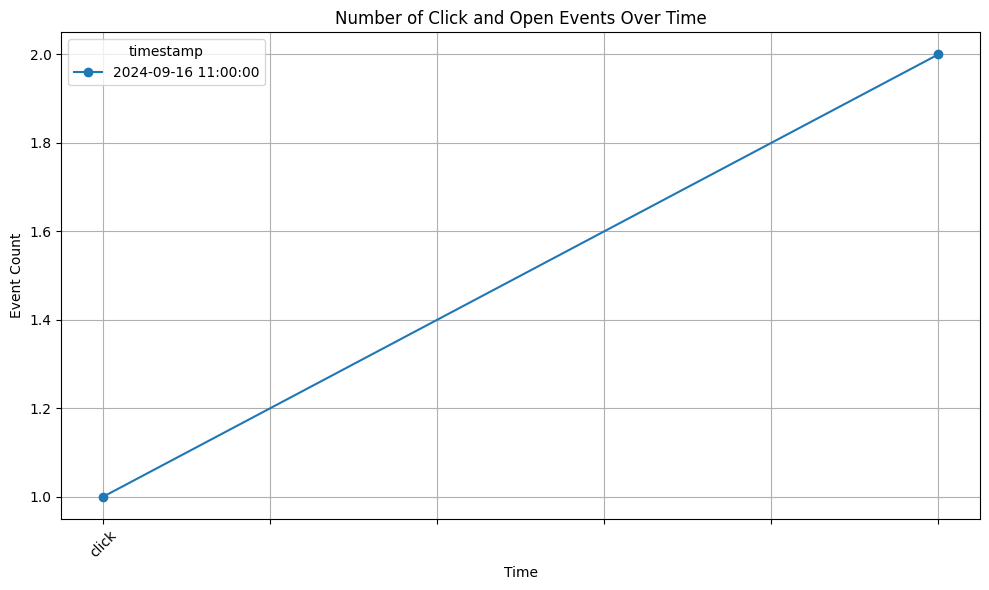

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def analyze_logs():
    if os.path.exists(log_filename):
        # Read log data from CSV
        df = pd.read_csv(log_filename, names=['timestamp', 'type', 'ipaddress'])

        # Convert timestamp to datetime format
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Table showing the number of click and open events for each IP
        ip_summary = df.groupby(['ipaddress', 'type']).size().unstack(fill_value=0)
        print("\n=== Log Analysis: Events per IP ===")
        display(ip_summary)  # Show the table in Colab

        # Group by timestamp (resampled by hour or minute depending on data)
        df.set_index('timestamp', inplace=True)
        resampled_data = df.groupby(['type']).resample('H').size().unstack(fill_value=0)

        # Plotting the time-series data
        plt.figure(figsize=(10, 6))
        resampled_data.plot(kind='line', marker='o', ax=plt.gca())
        plt.title('Number of Click and Open Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Event Count')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        print("No log file found!")

# 종료 후 통계 분석
analyze_logs()
